## Convolutional Autoencoder

In this notebook, we will be implementing a simple Autoencoder for images. Autoencoders are a type of neural networks that learn the features from the data by compressing the data and then reproducing the output same as input. 

### Architecture:

***Input Data  =>  Encoder  => Hidden Layer  =>   Decoder  =>  Output Data***

Note that the Input Data == Output Data.

The number of nerons in the Input Layer i.e. Encoder == number of neurons in Output Layer i.e. Decoder.

The hidden layer is where the magic happens. The hidden layer may have the number of neurons that might be less than the Output Layer (i.e. "Undercomplete Autoencoder") or if the number of neurons are more in the Hidden layer than the Output Layer (i.e. "Overcomplete Autoencoder").

The Encoder for a Convolutional Autoencoder uses Convolution layers instead of the Fully Connected Layers as in the linear Autoencoder followed by MaxPooling layer. 

At the Hidden Layer, the model takes in the data from a higher dimension and compresses it into lower dimension by learning features from the Input Data.

Once the features are learnt, the data moves to the Decoder part which uses Transposed Convolutions along with Maxpooling to get the final image equal to the size of the Input Image. Sometimes, during the decoding process, the image gets blurry or appears in form of blocks. So, to avoid that, we use Upsampling.

In [1]:
# Import Dependencies
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\hare krishna\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load Dataset
fashion_mnist = input_data.read_data_sets('./dataset/fashion-MNIST/', one_hot=True)

Extracting ./dataset/fashion-MNIST/train-images-idx3-ubyte.gz
Extracting ./dataset/fashion-MNIST/train-labels-idx1-ubyte.gz
Extracting ./dataset/fashion-MNIST/t10k-images-idx3-ubyte.gz
Extracting ./dataset/fashion-MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# Shapes of training set
print("Training set (images) shape: ",fashion_mnist.train.images.shape)
print("Training set (labels) shape: ",fashion_mnist.train.labels.shape)

# Shapes of test set
print("Test set (images) shape: ", fashion_mnist.test.images.shape)
print("Test set (labels) shape: ", fashion_mnist.test.labels.shape)

Training set (images) shape:  (55000, 784)
Training set (labels) shape:  (55000, 10)
Test set (images) shape:  (10000, 784)
Test set (labels) shape:  (10000, 10)


In [4]:
# Create a list of what each label means
label_names = ['T-Shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

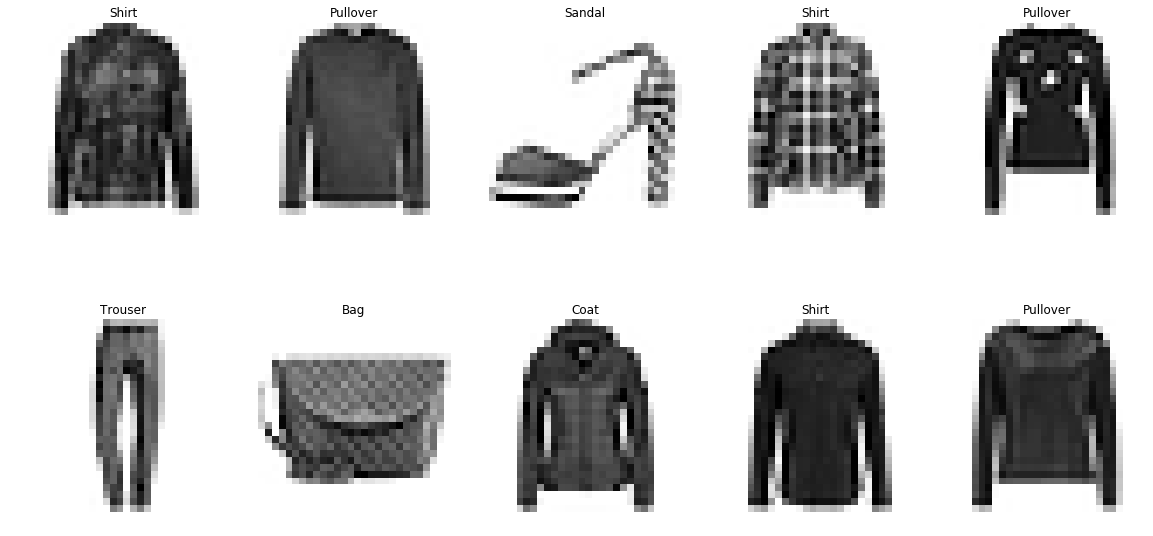

In [5]:
# Plot Random Image
n = np.random.randint(0,55000,10)
names = []

# Get the Index for Label_Names array and append names to array []
with tf.Session() as sess:
    for i in range(len(n)):
        l = tf.argmax(fashion_mnist.train.labels[n][i], axis=0)
        names.append(label_names[sess.run(l)])
sess.close()

# Plot Images
fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(20,10))
u = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(fashion_mnist.train.images[n][u].reshape(28,28), cmap='Greys')
        ax[i,j].set_axis_off()
        ax[i,j].set_title(names[u])
        u += 1

### Autoencoder Modle

In [6]:
# Define Constants
# Learning Rate
lr = 0.001

In [7]:
# Define Placeholders
# Input Image
input_image = tf.placeholder(tf.float32,shape=[None,28,28,1], name="input_image")

# Target Image / Reproduced Image
target_image = tf.placeholder(tf.float32,shape=[None,28,28,1], name="output_image")

### Encoder

In [8]:
# Encoder Module
with tf.name_scope('Encoder'):
    # First Convolutional layer
    conv1 = tf.layers.conv2d(inputs=input_image, filters= 16, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv1')
    # Max Pooling 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2,2), strides=(2,2), padding= 'same', name='Pool1')
    # Second Convolutional layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters= 8, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv2')
    # Max Pooling 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2,2), strides=(2,2), padding= 'same', name='Pool2')
    # Third Convolutional layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters= 8, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv3')
    # Max Pooling 3
    encoded_image = tf.layers.max_pooling2d(inputs=conv3, pool_size=(2,2), strides=(2,2), padding= 'same', name='Encoded_Image')
    

### Decoder

For the decoder we have two options:

**1. Use Transposed Convolutions:**

This works in opposite way as compared to a convolution process and gets us the original image size output. The drawback of using thi sapproach is that in the output image generated, we may see some checkblocks. Hence, the image is not as clear as expected.

**2. Resize using UpSampling and use Convolutions:**

Using this approach has proven to be better as compared to the first approach as using this we can get much better images at the output.

In [9]:
# Decoder Module
# Input = encoded_image
with tf.name_scope('Decoder'):
    # Upsampling Image to get Better Quality Image at Output
    upsample_image1 = tf.image.resize_images(images=encoded_image, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv1 = tf.layers.conv2d(inputs=upsample_image1, filters= 8, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv1')
    # Upsampling Image to get Better Quality Image at Output
    upsample_image2 = tf.image.resize_images(images=deconv1, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv2 = tf.layers.conv2d(inputs=upsample_image2, filters= 8, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv2')
    # Upsampling Image to get Better Quality Image at Output
    upsample_image3 = tf.image.resize_images(images=deconv2, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv3 = tf.layers.conv2d(inputs=upsample_image3, filters= 16, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv3')
    logits = tf.layers.conv2d(inputs=deconv3, filters=1, kernel_size=(3,3), padding='same', activation=None, name='logits')
    # Pass logits through sigmoid to get reconstructed image
    decoded_image = tf.nn.sigmoid(logits, name='Decoded_Image')

In [10]:
# Cost Function:Cross Entropy With Logits
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_image, logits=logits))

# Optimizer
optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

# Define a Model Saver
save_model = tf.train.Saver()

In [11]:
# Helper Function to Plot Generated Images at Decoder
def plot_images():
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    test_images = fashion_mnist.test.images[:10]
    decoder_out = sess.run(decoded_image, feed_dict={input_image: test_images.reshape((10, 28, 28, 1))})

    for images, row in zip([test_images, decoder_out], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
    fig.tight_layout(pad=0.1)

In [12]:
# Initialize all Variables
init = tf.global_variables_initializer()

Epoch: 1	 Training Loss: 0.3201
Epoch: 2	 Training Loss: 0.2958
Epoch: 3	 Training Loss: 0.2979
Epoch: 4	 Training Loss: 0.2955
Epoch: 5	 Training Loss: 0.2975
Epoch: 6	 Training Loss: 0.2898
Epoch: 7	 Training Loss: 0.2871
Epoch: 8	 Training Loss: 0.2807
Epoch: 9	 Training Loss: 0.2813
Epoch: 10	 Training Loss: 0.2888
Epoch: 11	 Training Loss: 0.2772
Epoch: 12	 Training Loss: 0.2798
Epoch: 13	 Training Loss: 0.2818
Epoch: 14	 Training Loss: 0.3025
Epoch: 15	 Training Loss: 0.2761
Epoch: 16	 Training Loss: 0.2798
Epoch: 17	 Training Loss: 0.2987
Epoch: 18	 Training Loss: 0.2905
Epoch: 19	 Training Loss: 0.2859
Epoch: 20	 Training Loss: 0.2824


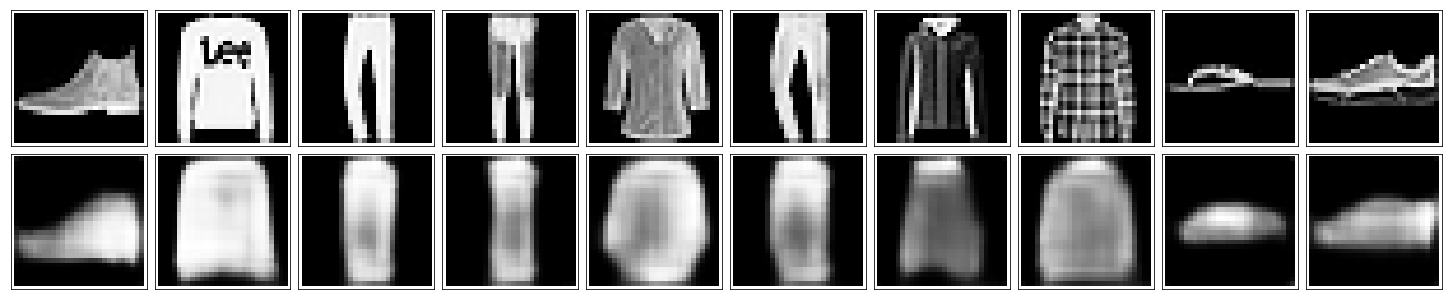

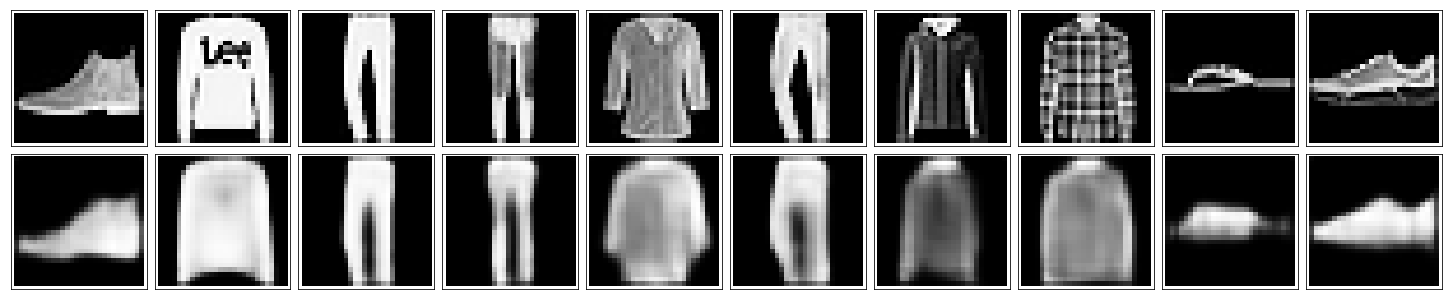

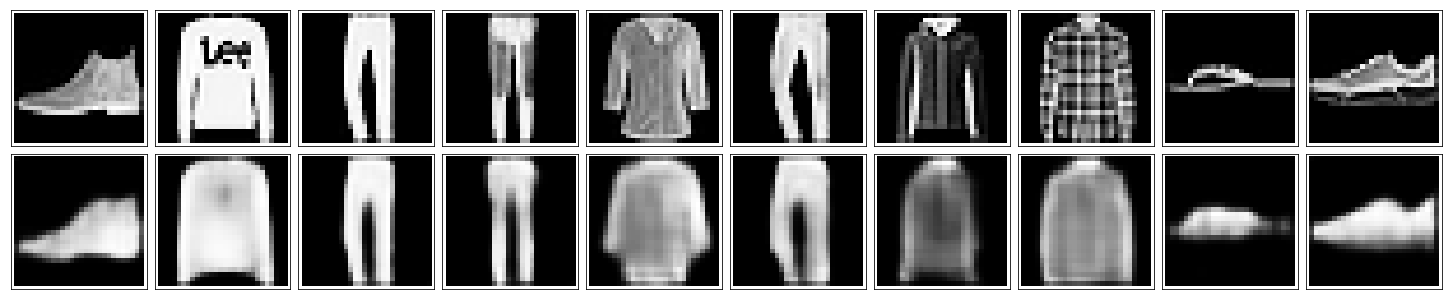

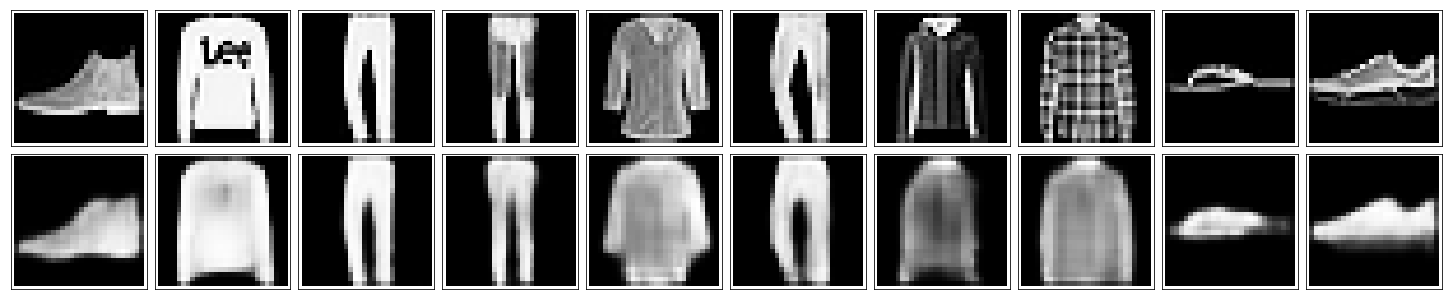

In [13]:
# Run and Save the Trained Model
with tf.Session() as sess:
    sess.run(init)
    
    # Save Current Session Graph
    writer = tf.summary.FileWriter('./output', sess.graph)
    
    # Number of Epochs to run for
    epochs= 20
    # Batch Size: Number of Images in each batch of Input Data
    batch_size = 200
    # Number of Batches
    n_batches = fashion_mnist.train.num_examples // batch_size
    
    for i in range(epochs):
        for j in range(n_batches):
            # Next Batch of Data
            batch = fashion_mnist.train.next_batch(batch_size)
            # Load Images
            img = batch[0].reshape((-1,28,28,1))
            # Run the Optimizer and Cost Functions
            result, loss_val = sess.run([optimizer, cost], feed_dict={input_image: img, target_image: img})
            
        print("Epoch: {}\t".format(i+1),"Training Loss: {:.4f}".format(loss_val))

    writer.close()
    
    # Save Trained Model
    save_model.save(sess,'./trained_model/')